# Problem Definition

Spanish Translation A/B Test

Goal:

1. Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
2. Explain why that might be happening. Are the localized translations really worse?
3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

In [1]:
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from scipy.stats import ttest_ind
matplotlib.style.use('ggplot')

%matplotlib inline

from scipy.stats import norm

In [4]:
test = pd.read_csv('data/test_table.csv', parse_dates=['date'])
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [6]:
user = pd.read_csv('data/user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [10]:
# there are some missing value in the user table.
test.shape,user.shape

((453321, 9), (452867, 4))

In [14]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in test.columns:
    uniques = test[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:7])

Variable     count of unique value    content
user_id              453321	 [315281 497851 848402 290051 548435 540675 863394]
date                    5	 ['2015-12-03T00:00:00.000000000' '2015-12-04T00:00:00.000000000'
 '2015-11-30T00:00:00.000000000' '2015-12-01T00:00:00.000000000'
 '2015-12-02T00:00:00.000000000']
source                  3	 ['Direct' 'Ads' 'SEO']
device                  2	 ['Web' 'Mobile']
browser_language        3	 ['ES' 'Other' 'EN']
ads_channel             6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
browser                 7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
conversion              2	 [1 0]
test                    2	 [0 1]


In [16]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in user.columns:
    uniques = sorted(user[column].unique())
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:7])

Variable     count of unique value    content
user_id              452867	 [1, 2, 3, 5, 8, 11, 12]
sex                     2	 ['F', 'M']
age                    52	 [18, 19, 20, 21, 22, 23, 24]
country                17	 ['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Ecuador', 'El Salvador']


Check two tables if there exists repeated users.

In [17]:
# Check uniqueness

print('Test table Unique User Ids:\t', len(test['user_id'].unique()),'\t',
      len(test['user_id'].unique())==len(test['user_id']) )
print('User table Unique User Ids:\t', len(user['user_id'].unique()),'\t',
      len(user['user_id'].unique())==len(user['user_id']) )

Test table Unique User Ids:	 453321 	 True
User table Unique User Ids:	 452867 	 True


It is clear that two tables do not have repeated users and for some users in the test set, we miss their information about sex, age and country. Thus, when joining, we have to guarantee the compeleteness of user ids in the test table. I am planning to let user table to left join test table.

In [11]:
data = pd.merge(left=test, right=user, how='left', on='user_id' )
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 453321 entries, 0 to 453320
Data columns (total 12 columns):
user_id             453321 non-null int64
date                453321 non-null datetime64[ns]
source              453321 non-null object
device              453321 non-null object
browser_language    453321 non-null object
ads_channel         181877 non-null object
browser             453321 non-null object
conversion          453321 non-null int64
test                453321 non-null int64
sex                 452867 non-null object
age                 452867 non-null float64
country             452867 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 45.0+ MB


In [21]:
data.columns
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


# A/B Test

First check that Spain converts much better than the rest of LatAm countries 

1. Confirm that the test is actually negative.
First, we need to prove that in the control group, spain performs better.

In [31]:
groupby_country = data[data['test'] == 0][['conversion', 'country']].groupby('country').mean()
groupby_country = groupby_country.reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending=False)

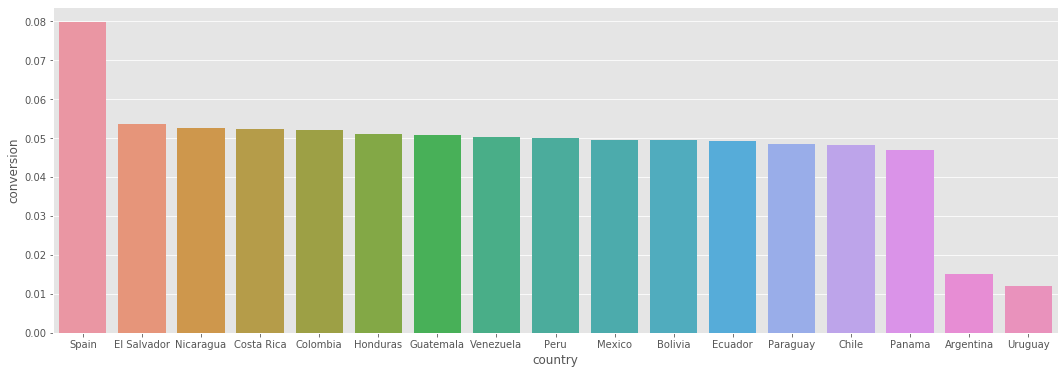

In [32]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)
plt.show()

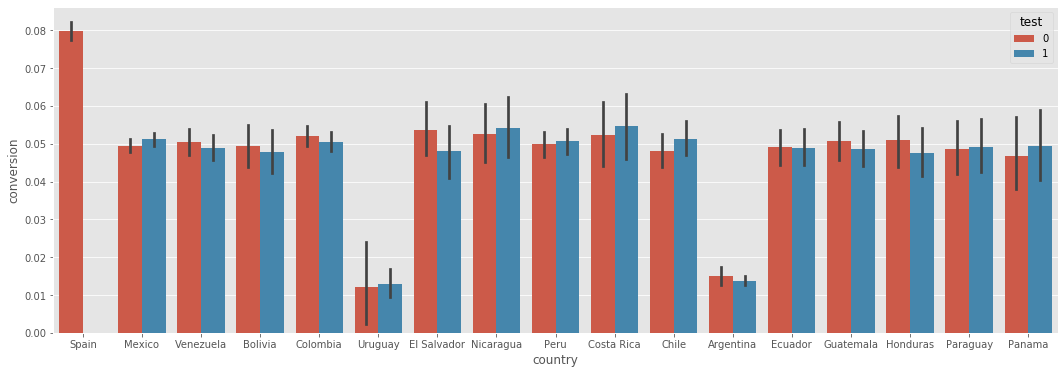

In [33]:
# Visualization
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax)
plt.show()
#From the barplot above, it seems that the control groups perform worse. We need some statistal methods to prove it.
#Obviously, Spain does have the highest mean conversion rate among all countries. Now I am trying to confirm that the test is negative by using t test.

In [34]:
# A/B test
test_data = data[data['country'] != 'Spain']
test_val = test_data[test_data['test'] == 1]['conversion'].values
cont_val = test_data[test_data['test'] == 0]['conversion'].values

In [35]:
print(test_val.mean(), '\t', cont_val.mean())

# Welch Two Sample t-test
print(ttest_ind(test_val, cont_val, equal_var=False))

0.043424713982118966 	 0.04833042316066309
Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)



We can see that control group without changing translation has a converting at 4.8%, however, users in test group with localized translation just convert at 4.3%. It does have a negative effect for changing translation.

# Explain why that might be happening. Are the localized translations really worse?


In order to answer this question, I will first visualize multiple variables by breaking data into control and test group to give me some insights.

Likely, there is for some reason some segment of users more likely to end up in test or in control, this segment had a significantly above/below conversion rate and this affected the overall results.

In [36]:
data = data[data['country'] != 'Spain']
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
5,540675,2015-12-03,Direct,Mobile,ES,NaN,Android_App,0,1,F,22.0,Venezuela
6,863394,2015-12-04,SEO,Mobile,Other,NaN,Android_App,0,0,M,35.0,Mexico


In [42]:
Cont=data[data['test']==0]
Test=data[data['test']==1]

In [39]:
def visualization(data1,data2,nrows,ncols):
    columns = data.select_dtypes(include=['object']).columns[1:7]
    print('-' * 32,'Meansure each variable performance on control and test group','-' * 32)
    print(' ' * 100)
    for column in columns:
        # Source variable visualization on control and test group
        fig, ax = plt.subplots(nrows,ncols,figsize=(18,6))
        sns.countplot(data1[column],ax=ax[0,0],order=sorted(data1[column].value_counts().index))
        sns.countplot(x=data1[column],hue=data1['conversion'],ax=ax[0,1],order=sorted(data1[column].value_counts().index))
        sns.barplot(data1['conversion'],data1[column],ax=ax[0,2],order=sorted(data1[column].value_counts().index))
        sns.countplot(data2[column],ax=ax[1,0],order=sorted(data2[column].value_counts().index))
        sns.countplot(x=data2[column],hue=data2['conversion'],ax=ax[1,1],order=sorted(data2[column].value_counts().index))
        sns.barplot(data2['conversion'],data2[column],ax=ax[1,2],order=sorted(data2[column].value_counts().index))
        fig.subplots_adjust(top=0.2)
        fig.suptitle('Control vs Test',fontsize=14)
        plt.tight_layout()

-------------------------------- Meansure each variable performance on control and test group --------------------------------
                                                                                                    


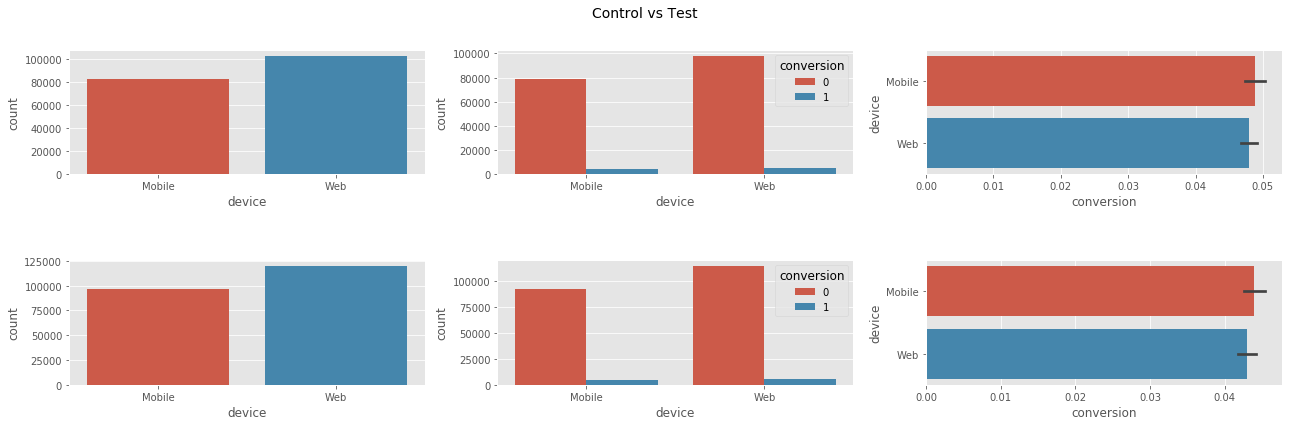

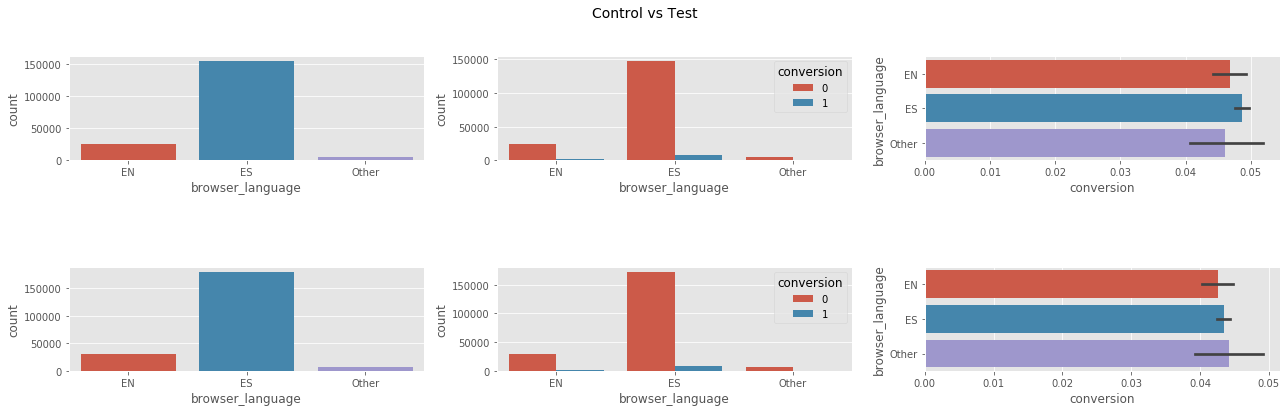

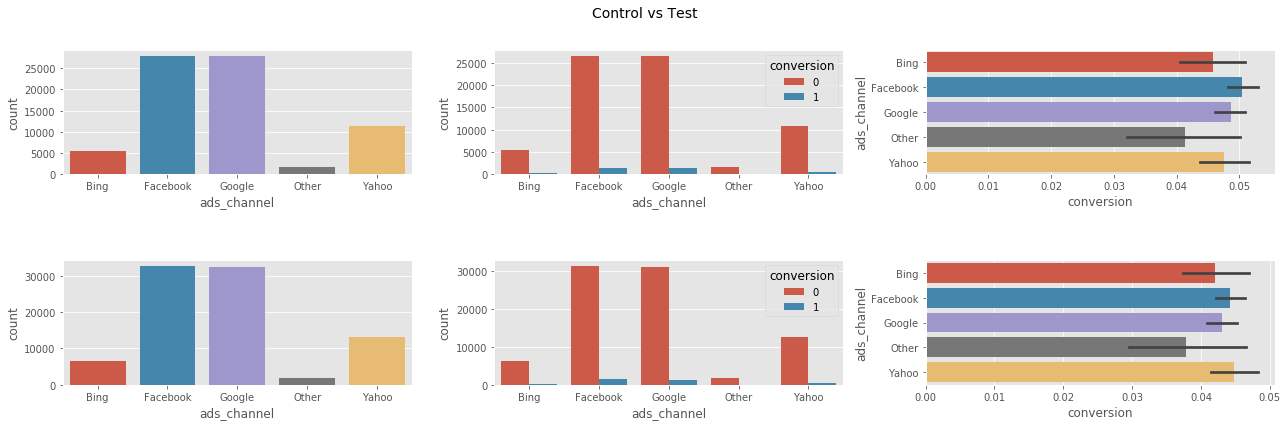

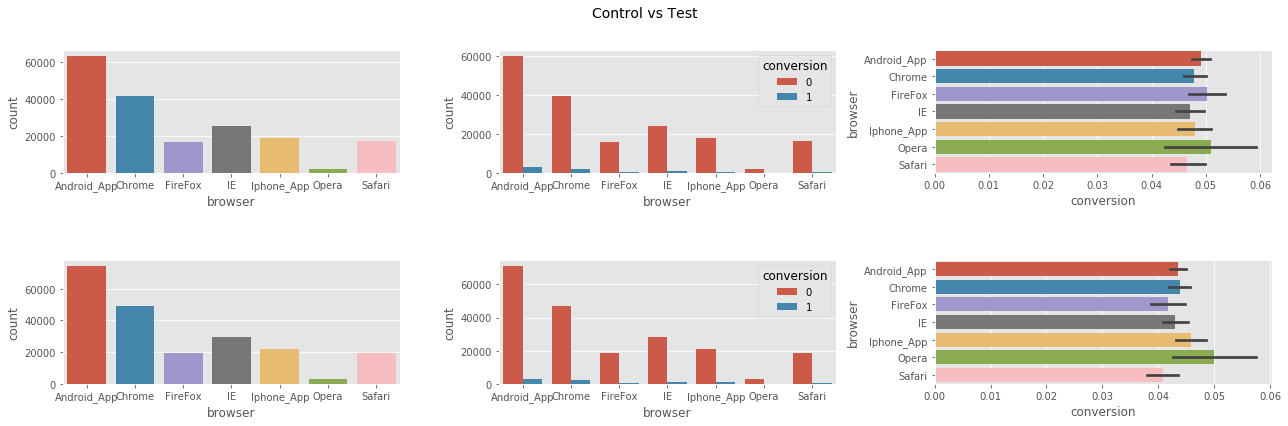

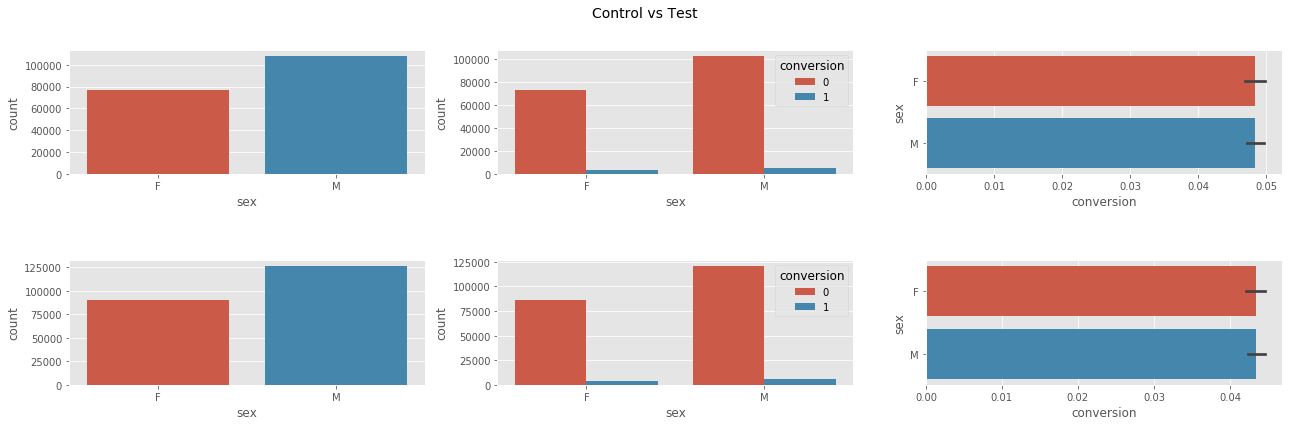

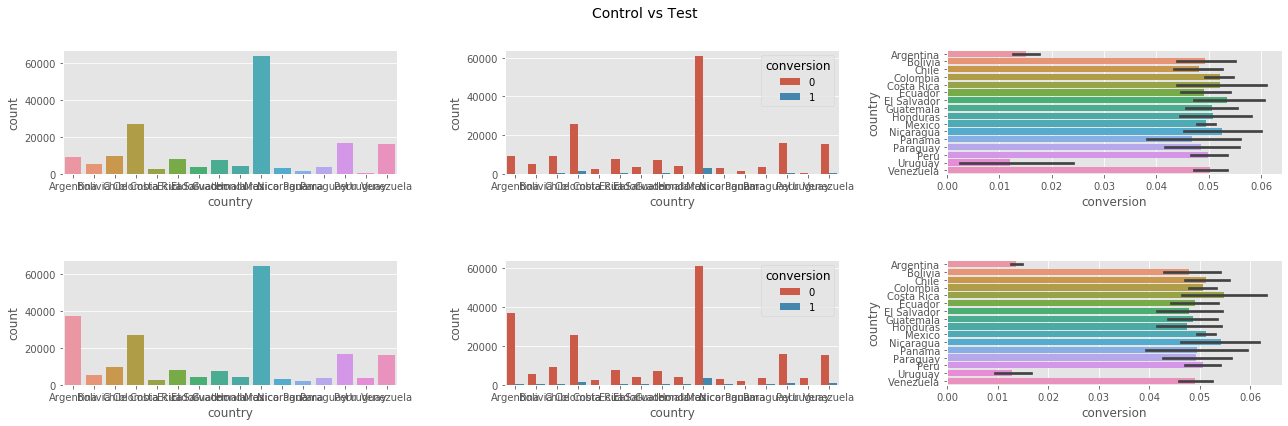

In [43]:
visualization(Cont,Test,2,3)

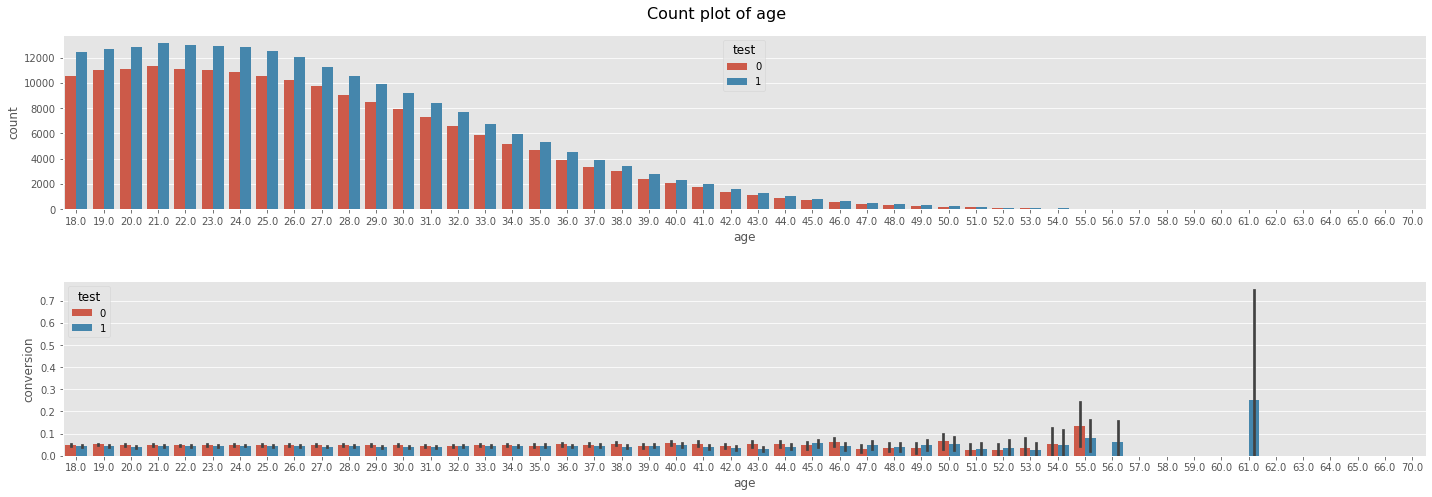

In [45]:

#  Age variable visualization
fig,ax=plt.subplots(2,1,figsize=(20,7))
sns.countplot(x='age',hue='test',data=data,ax=ax[0])
sns.barplot(x=data['age'],y=data['conversion'],hue=data['test'],ax=ax[1]);
fig.suptitle('Count plot of age',fontsize=16)
fig.subplots_adjust(top=0.25)
plt.tight_layout()

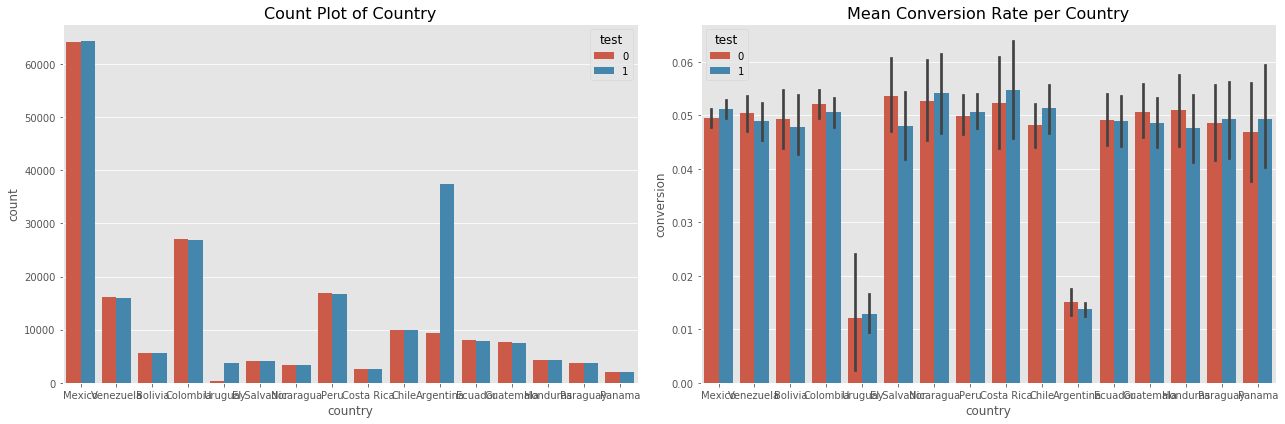

In [46]:
# Visualization of different devices
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='test', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)

sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

In [47]:
# let check for each country

countries = [name for name in data['country'].unique() if name is not np.nan]

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion'].values
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion'].values
    
    test_mean = test_val.mean()
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  

# Conclusion:¶
From analysis of the data, there does appear to be higher conversion rates with the standarized Spanish translations.
However, this particular experiment should be invalidated due to biased sampling in Uruguay and Argentina.
Additionally, the "English" and "Other" values in the browser_language variable should be excluded from the study since the source of the Spanish translation (the experimental condition) does not affect those two values. Any result from those two values will bring more variance to the data.
There is about an equal split in the number of countries that show positive change and negative change between the standard and local translations.